In [23]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
# import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

from sklearn.model_selection import train_test_split

In [56]:
import tensorflow as tf
print(tf.__version__)


2.14.0


In [25]:
import glob
import os
import math
import operator
import functools
import random
import datetime
from scipy.ndimage.interpolation import rotate, shift, zoom

In [28]:
# load data set
all_X = np.load('X.npy')
all_Y = np.load('Y.npy')

In [29]:
# Train Test split
test_size = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size=test_size, random_state=42)

In [30]:
print('Training shape:', X_train.shape)
print(X_train.shape[0], 'sample,',X_train.shape[1] ,'x',X_train.shape[2] ,'size grayscale image.\n')
print('Test shape:', X_test.shape)
print(X_test.shape[0], 'sample,',X_test.shape[1] ,'x',X_test.shape[2] ,'size grayscale image.\n')

Training shape: (1752, 64, 64)
1752 sample, 64 x 64 size grayscale image.

Test shape: (310, 64, 64)
310 sample, 64 x 64 size grayscale image.



In [31]:
# Train and test classification between 0-10
Y_test_cls = np.argmax(Y_test, axis=1)
Y_train_cls = np.argmax(Y_train, axis=1)

In [32]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 64

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [36]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 4
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

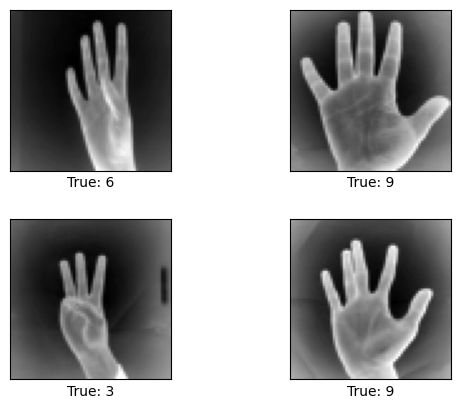

In [37]:
# Get the first images from the test-set.
images = X_test[0:4]

# Get the true classes for those images.
cls_true = Y_test_cls[0:4]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [38]:
train_X = X_train
train_Y = Y_train
new_train_X = train_X.reshape(X_train.shape[0],img_size_flat)
new_test_X = X_test.reshape(X_test.shape[0],img_size_flat)

In [39]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=new_train_X.shape))
print("Training set (labels) shape: {shape}".format(shape=train_Y .shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=new_test_X.shape))
print("Test set (labels) shape: {shape}".format(shape=Y_test.shape))


Training set (images) shape: (1752, 4096)
Training set (labels) shape: (1752, 10)
Test set (images) shape: (310, 4096)
Test set (labels) shape: (310, 10)


In [40]:
# architecture hyper-parameter
learning_rate = 0.001
training_iters = 40000
batch_size = 16
display_step = 20

n_input = img_size_flat # 64x64 image
dropout = 0.75 

In [52]:

x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)
print('Shape of placeholder',x.shape, y.shape)

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [51]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [53]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [54]:
def conv_net(x, weights, biases, dropout):
    # reshape input to 64x64 size
    x = tf.reshape(x, shape=[-1, 64, 64, 1])
    

    # Convolution layer 1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max pooling
    conv1 = maxpool2d(conv1, k=2)

    # Convolution layer 2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max pooling
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1) # layer
    fc1 = tf.nn.dropout(fc1, dropout)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [55]:
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32]),name='wc1'),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64]),name='wc2'),
    'wd1': tf.Variable(tf.random_normal([64 * 64 * 4, 1024]),name='wd1'),
    'out': tf.Variable(tf.random_normal([1024, num_classes]),name='wout')
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32]),name='bc1'),
    'bc2': tf.Variable(tf.random_normal([64]),name='bc2'),
    'bd1': tf.Variable(tf.random_normal([1024]),name='bd1'),
    'out': tf.Variable(tf.random_normal([num_classes]),name='bout')
}

AttributeError: module 'tensorflow' has no attribute 'random_normal'